# <center> **Analsis exploratorio de los datos** </center>

## Importar librerias

In [2]:
# Importar librerias
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode
from sklearn import preprocessing
import warnings
import sqlite3
import plotly.graph_objects as go


## Cargar datos

In [3]:
try:
    # Leer el archivo CSV ubicado en la ruta especificada y asigna los datos a la variable df_resultados
    df_casos_covid_colombia = pd.read_csv('casos_covid_colombia.csv')

    # Si la lectura del archivo es exitosa, imprime un mensaje indicando que el dataset se cargó correctamente
    print("Dataset cargado correctamente")

# Si se produce un error específico de "FileNotFoundError" (archivo no encontrado), ejecuta este bloque de código
except FileNotFoundError as e:

    # Imprime un mensaje de error personalizado indicando que el archivo no se pudo encontrar, junto con los detalles específicos del error
    print(f"Error: no se encuentra el archivo. Detalles {e}")

# Si se produce cualquier otro tipo de error, ejecuta este bloque de código
except Exception as ex:

    # Imprime un mensaje de error genérico indicando que ocurrió un error inesperado, junto con los detalles específicos del error
    print(f"Error: es otro tipo de error. Detalles {ex}")

Dataset cargado correctamente


In [4]:
# Consulta y validación de la cantidad de filas y columnas del dataframe
num_rows, num_cols = df_casos_covid_colombia.shape

# Imprimir mensaje y valores de salidas del dataframe
print(f'El Dataframe tiene {num_rows} filas y {num_cols} columnas.')

El Dataframe tiene 6387921 filas y 16 columnas.


In [5]:
df_casos_covid_colombia.columns

Index(['FECHA_DE_NOTIFICACION', 'EDAD', 'UNIDAD_DE_MEDIDA_DE_EDAD', 'SEXO',
       'TIPO_DE_CONTAGIO', 'UBICACION_DEL_CASO', 'ESTADO', 'RECUPERADO',
       'FECHA_DE_INICIO_DE_SINTOMAS', 'FECHA_DE_MUERTE',
       'FECHA_DE_DIAGNOSTICO', 'FECHA_DE_RECUPERACION', 'PERTENENCIA_ETNICA',
       'NOMBRE_DEPARTAMENTO', 'NOMBRE_MUNICIPIO', 'NOMBRE_PAIS'],
      dtype='object')

## Varibles de caracterización de la población

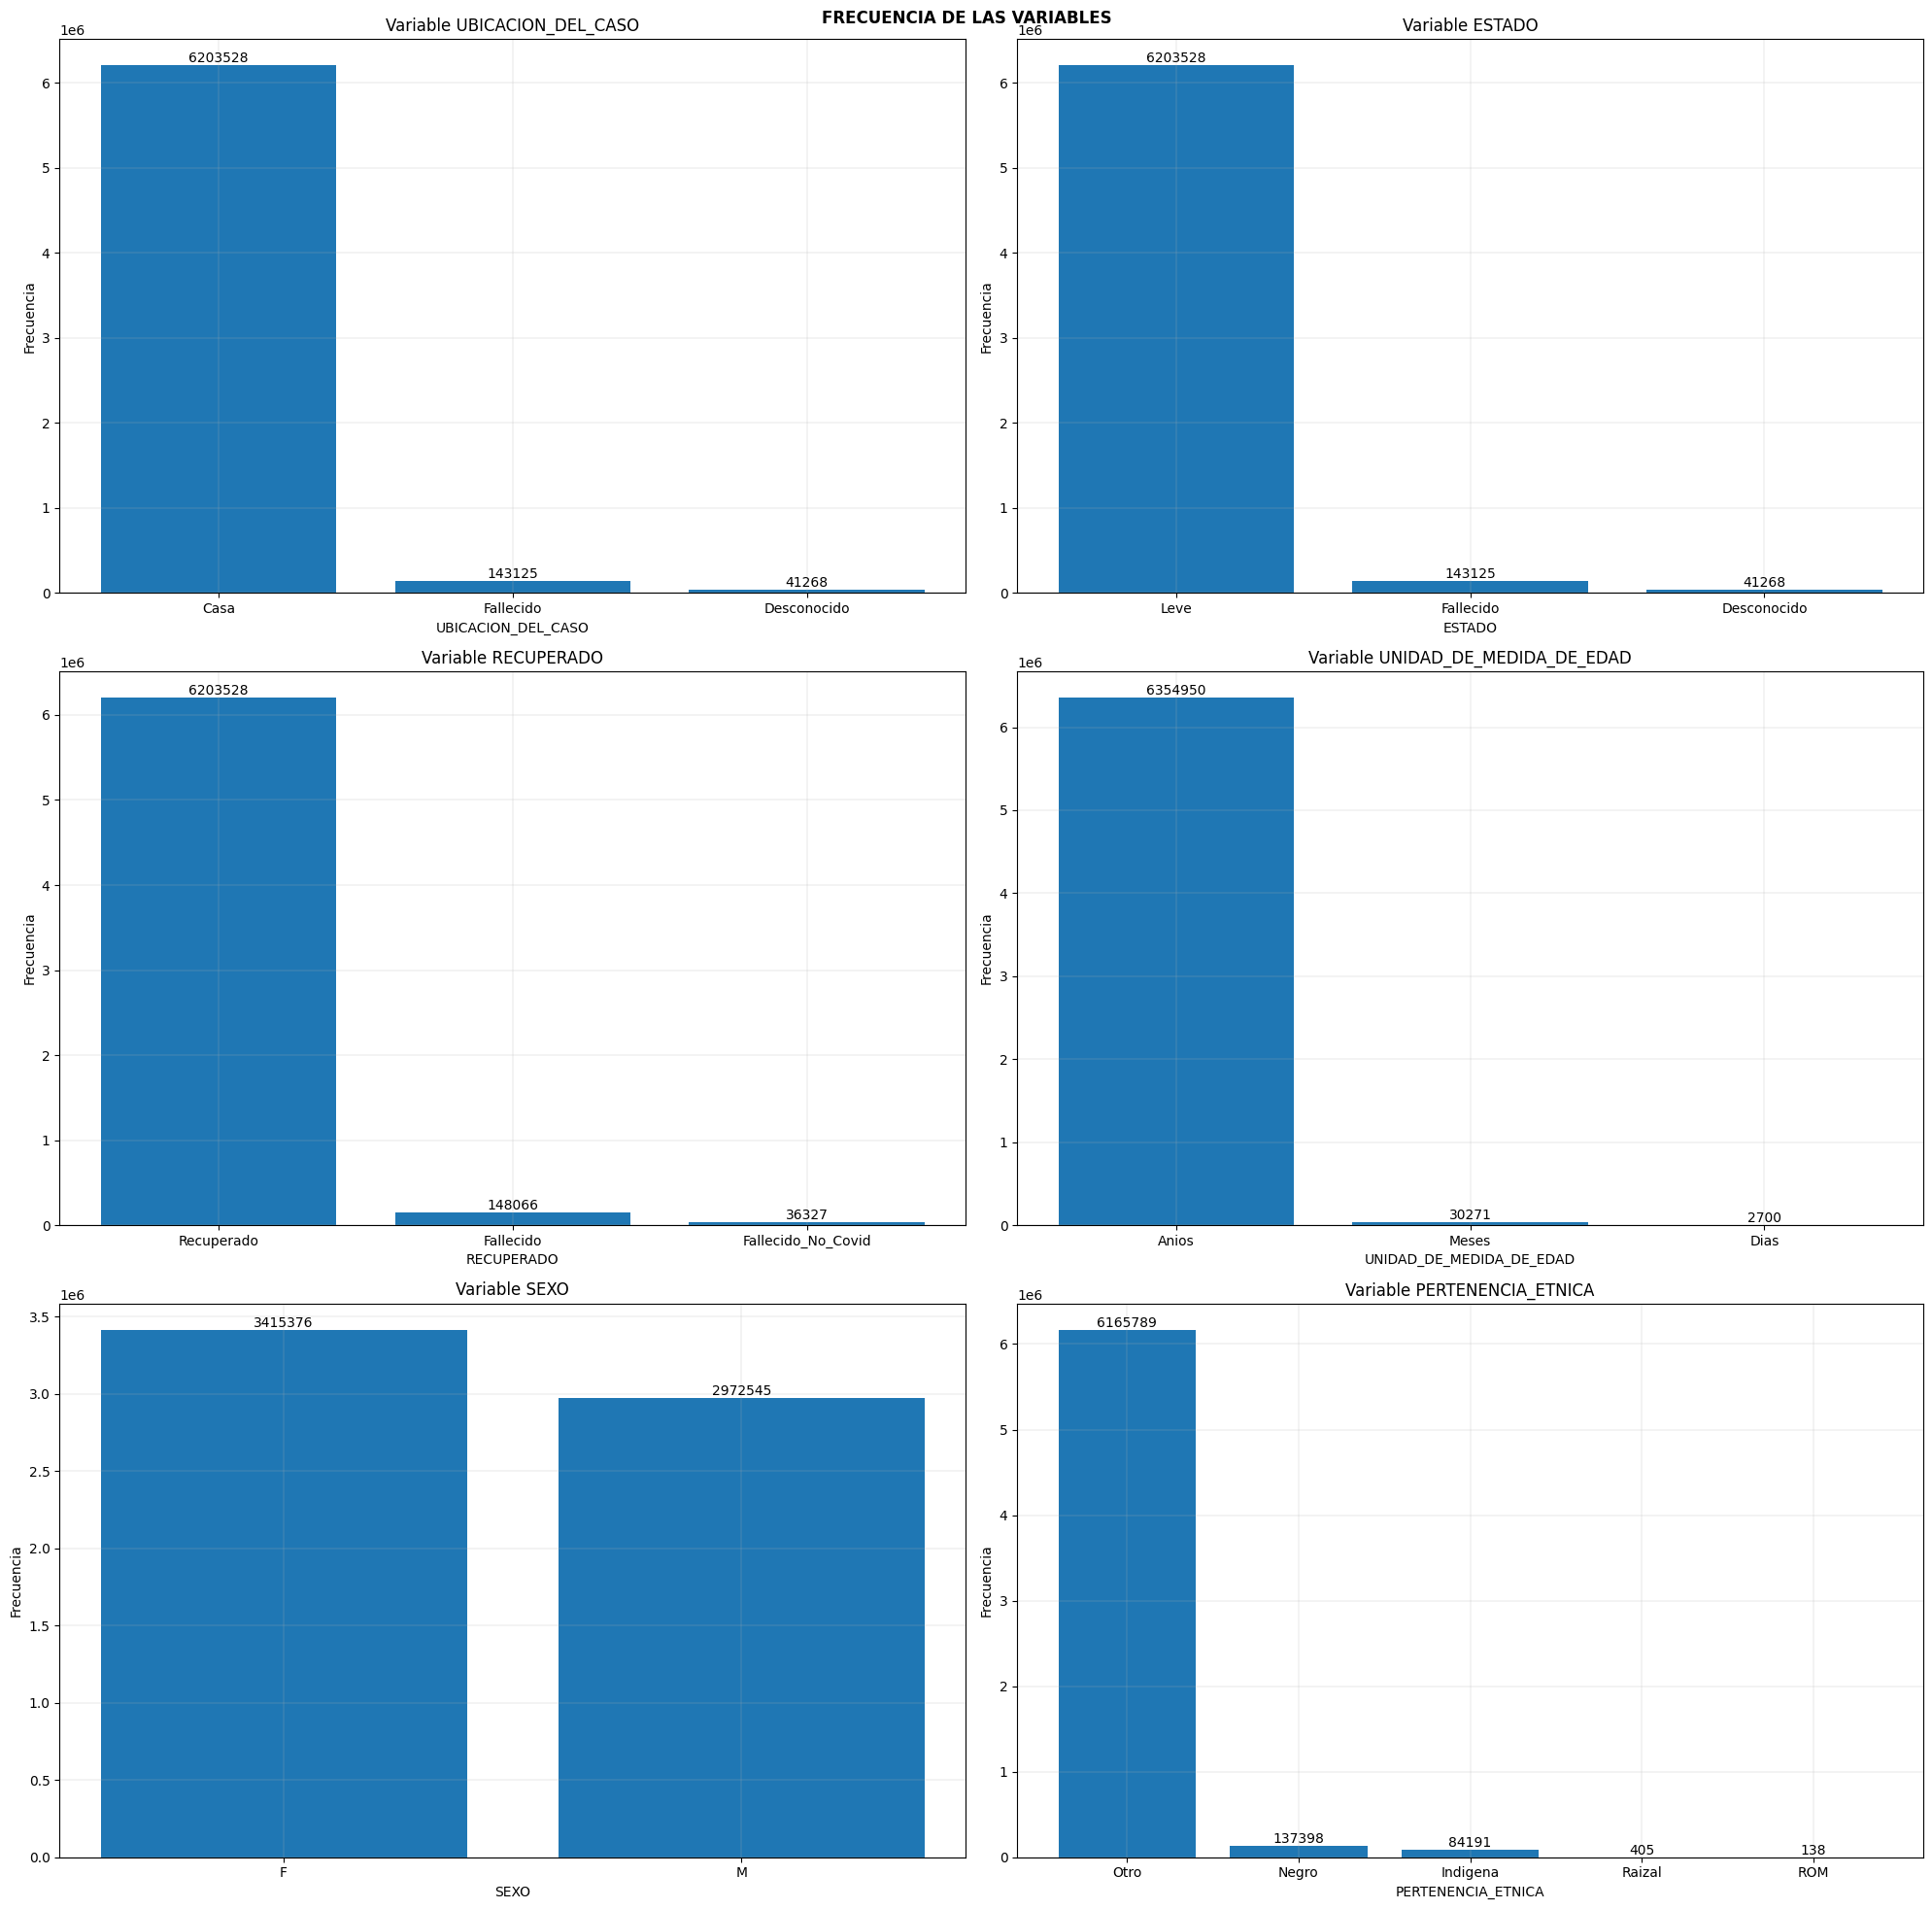

In [6]:
# Columnas con nombres de categorías 
selected_columns = ['UBICACION_DEL_CASO', 'ESTADO', 'RECUPERADO', 'UNIDAD_DE_MEDIDA_DE_EDAD', 'SEXO', 'PERTENENCIA_ETNICA']

# Filtrar el DataFrame para incluir solo las columnas especificadas
df_filtered = df_casos_covid_colombia[selected_columns]

# Crear una figura con una cuadrícula de 5x5
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

# Establecer el supertítulo
fig.suptitle('FRECUENCIA DE LAS VARIABLES', fontweight='extra bold')

# Iterar sobre las columnas y los ejes para crear los gráficos
for idx, col in enumerate(df_filtered.columns):
    # Calcular la fila y columna en la cuadrícula
    row = idx // 2
    col_idx = idx % 2
    
    # Obtener el eje correspondiente en la cuadrícula
    ax = axes[row, col_idx]
    
    # Crear el gráfico de barras
    value_counts = df_filtered[col].value_counts()
    # Convertir los índices a cadenas
    x_labels = [str(idx) for idx in value_counts.index]
    # Crear el gráfico de barras
    bars = ax.bar(x_labels, value_counts.values)

    
    # Establecer el título del gráfico
    ax.set_title(f'Variable {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frecuencia')
    ax.grid(linestyle='-', linewidth=0.2)
    
    # Etiquetas de valores en las barras
    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f'{bar.get_height():.0f}',  # Formatear el valor como entero
            ha='center',
            va='bottom'
        )


# Ajustar el diseño y mostrar los gráficos
plt.tight_layout()
plt.show()

- Al examinar las variables `ubicación del caso`, `estado` y `recuperado`, observamos que las tres categorías principales (*casa*, *leve* y *recuperado*) presentan la **misma frecuencia**. Además, las frecuencias de las demás categorías son bastante similares, lo que sugiere una posible relación entre ellas.

Sin embargo, al comparar la suma de las frecuencias de todas las categorías con la cantidad total de datos en la base de datos ($6.387.921$), se detecta una discrepancia de $5.015$ casos. Esta diferencia nos llevó a investigar la situación en detalle, llegando a la siguiente imagen:


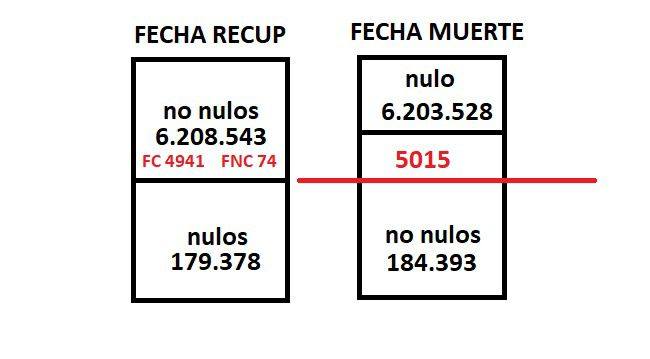

La investigación detallada reveló que los $5.015$ casos que generaron la discrepancia corresponden a pacientes que inicialmente fueron clasificados como *recuperados* del **COVID-19**, pero que posteriormente *fallecieron* a causa de la enfermedad. Esta situación se explica por el hecho de que el sistema de categorización no siempre se actualiza de manera inmediata, lo que puede generar un desfase temporal entre la recuperación inicial y el posterior fallecimiento.

- Al examinar la variable `unidad de mediad de edad`, observamos que en el $99,4\%$ de los casos registrados la categoría es *años*. Esto indica que la población afectada por el **COVID-19** en el conjunto de datos está compuesta principalmente por personas de **al menos un año de edad**. Esta información es relevante evaluar el impacto del virus en diferentes segmentos de la población.

- Al examinar la variable `sexo`, observamos que las frecuencias de las categorías *masculino* y *femenino* son bastante similares. Sin embargo, la categoría *femenino* presenta una frecuencia ligeramente mayor, lo que sugiere una posible diferencia en la distribución de casos por sexo. 

- Al examinar la variable `pertenencia étnica`, observamos que el $96,5\%$ de los casos ha utilizado la categoría *otros* como identificación de su etnia. Esta alta proporción sugiere que una gran parte de la población afectada por **COVID-19** en el conjunto de datos no se identifica con ningún grupo étnico reconocido o representa un caso muy especial que no se ajusta a las categorías predefinidas.

## Variables temporales

Para poder usar estas variables en un analisis primero tenemos que poder configurar dichas vairables para tener la información bien organizada 

In [7]:
# Columnas con nombres de categorías 
selected_columns = ['FECHA_DE_INICIO_DE_SINTOMAS', 'FECHA_DE_MUERTE', 'FECHA_DE_DIAGNOSTICO', 
                    'FECHA_DE_RECUPERACION']

# Crear un diccionario para almacenar los resultados
conteos_por_dia_dict = {}

# Iterar sobre cada columna
for col in selected_columns:
    # Convertir la columna a tipo datetime
    df_casos_covid_colombia[col] = pd.to_datetime(df_casos_covid_colombia[col])
    
    # Agrupar por día y contar los registros
    conteos_por_dia = df_casos_covid_colombia.groupby(pd.Grouper(key=col, freq='D')).size().reset_index(name='Conteo')
    
    # Renombrar la columna de fechas para claridad
    conteos_por_dia.rename(columns={col: 'Fecha'}, inplace=True)
    
    # Guardar el resultado en el diccionario
    conteos_por_dia_dict[col] = conteos_por_dia
    
    # Exportar el resultado a CSV
    conteos_por_dia.to_csv(f'{col}.csv', index=False)

# Mostrar los resultados
for col, df in conteos_por_dia_dict.items():
    print(f"Resultados para {col}:")
    print(df.head())  # Mostrar las primeras filas de cada DataFrame


Resultados para FECHA_DE_INICIO_DE_SINTOMAS:
       Fecha  Conteo
0 2020-02-27       1
1 2020-02-28       2
2 2020-02-29       2
3 2020-03-01       4
4 2020-03-02       4
Resultados para FECHA_DE_MUERTE:
       Fecha  Conteo
0 2020-03-07       1
1 2020-03-08       0
2 2020-03-09       0
3 2020-03-10       0
4 2020-03-11       0
Resultados para FECHA_DE_DIAGNOSTICO:
       Fecha  Conteo
0 2020-03-06       1
1 2020-03-07       0
2 2020-03-08       0
3 2020-03-09       2
4 2020-03-10       0
Resultados para FECHA_DE_RECUPERACION:
       Fecha  Conteo
0 2020-03-13       1
1 2020-03-14       1
2 2020-03-15       1
3 2020-03-16       0
4 2020-03-17       1


Las fechas se utilizaron como un conteo con frecuencia diaria. Cada vez que una fecha se registraba en una fila, se contaba como uno. Este proceso se repitió para todas las fechas disponibles para cada uno de los datos.
Ahora miraremos el comportamiento de estos **data frames** en un grafíco

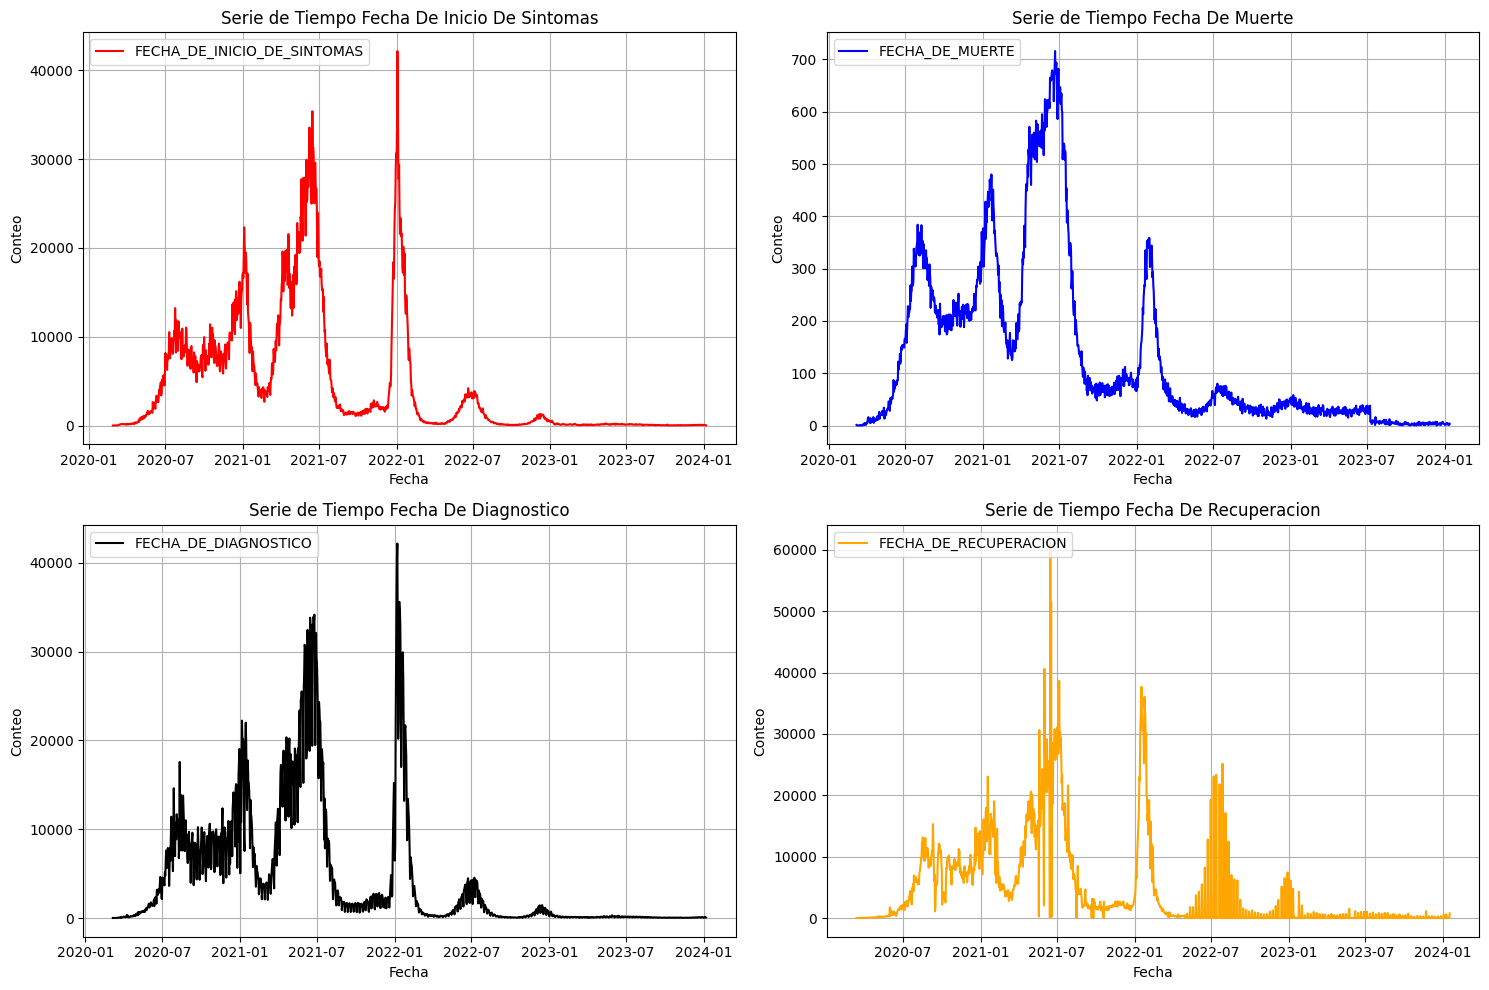

In [8]:
# Lista de colores
colors = ['red', 'blue', 'black' , 'orange']

# Configuración de la figura y subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 panel
axs = axs.flatten()  # Convertir la matriz 2x2 en una lista para iterar fácilmente

# Iterar sobre cada columna, su respectivo subplot y color
for ax, col, color in zip(axs, selected_columns, colors):
    # Leer los datos
    data = pd.read_csv(f'{col}.csv')
    data['Fecha'] = pd.to_datetime(data['Fecha'])
    
    # Crear la serie temporal
    Conteo = data.set_index('Fecha')
    Conteo_ts = Conteo['Conteo']
    
    # Graficar
    ax.plot(Conteo_ts, label=f'{col}', color=color)
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Conteo')
    ax.set_title(f'Serie de Tiempo {col.replace("_", " ").title()}')
    ax.grid(True)
    ax.legend(loc='upper left')

# Ajustar el layout
plt.tight_layout()
plt.show()

En general, las cuatro gráficas correspondientes a los períodos comprendidos entre *enero de 2020* y *enero de 2022* presentan un comportamiento similar. Además, las escalas utilizadas para las variables `fecha de diagnóstico`, `fecha de inicio de síntomas` y `fecha de recuperación` son comparables. Sin embargo, en el caso de la variable `fecha de muerte`, la escala empleada es significativamente diferente debido a la menor cantidad de datos disponibles.

- En cuanto a la `fecha de inicio de síntomas`, se observa un comportamiento con picos importantes en *fechas específicas*. Además, se detectan cambios de *tendencia* muy marcados en un *corto período de tiempo*, lo que coincide con la proximidad de las fechas de los picos. Cabe destacar que la naturaleza de esta variable, al ser un inicio de síntomas informado, implica que en varias ocasiones coincide con la `fecha de diagnóstico`.

- En cuanto a las `fechas de fallecimiento`, observamos un comportamiento similar al de las `fechas de diagnóstico`, con un leve **desplazamiento** de los picos. Esto podría explicarse por el hecho de que los picos de **alto contagio** precedían a los picos de *fallecimientos*, lo cual tiene sentido desde el punto de vista **epidemiológico**.

- En cuanto a la `fecha de recuperación`, se observan momentos claros en los que el valor desciende a $0$, lo que corta la serie de manera **abrupta** en varios puntos. A partir de fechas posteriores a *mayo de 2022*, aproximadamente, la serie se asemeja más a un histograma con barras puntuales. Debido a su complejidad, esta serie no se incluirá en el tablero.

- Para la fecha de diagnóstico, realizaremos un análisis más detallado utilizando una perspectiva más amplia


In [9]:
 # Leer los datos
data = pd.read_csv(f'FECHA_DE_DIAGNOSTICO.csv')
data['Fecha'] = pd.to_datetime(data['Fecha'])
    
# Crear la serie temporal
Conteo = data.set_index('Fecha')
Conteo_ts = Conteo['Conteo']



In [10]:
#Crear la figura
fig = go.Figure()

# Agregar la serie temporal con el área sombreada
fig.add_trace(go.Scatter(
    x=Conteo_ts.index,
    y=Conteo_ts.values,
    mode='lines',
    fill='tozeroy',
    name='# contagios',
    line=dict(color='orange')
))

# Configurar el layout
fig.update_layout(
    title='Serie de Tiempo Contagios covid-19',
    xaxis_title='Fecha',
    yaxis_title='# contagios en Colombia',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

# Mostrar la figura
fig.show()

La variable `fecha de diagnóstico` presenta características distintivas en comparación con la variable `fecha de inicio de síntomas`. Si bien la curva de diagnóstico es menos *suave* que la de inicio de síntomas, la naturaleza de la información de diagnóstico permite corroborar de manera definitiva un caso positivo de **COVID-19**. Esta característica la convierte en una variable de gran calidad para analizar el comportamiento de los casos confirmados (aspecto que se considera para su integración en el Business Intelligence).

- *Varianza marginal fluctuante*: La serie temporal de la variable `fecha de diagnóstico` presenta una varianza marginal fluctuante, lo que significa que el rango de valores de la variable se **amplia o disminuye a medida que transcurre el tiempo**.

- *Tendencia cambiante*: La tendencia de la variable `fecha de diagnóstico` fluctúa rápidamente y, en ocasiones, lo hace de manera **abrupta** con grandes saltos o caídas. Este comportamiento evidencia una volatilidad considerable y un patrón similar a una caminata aleatoria.

- *Potencial estacionalidad*: Se observa un comportamiento que sugiere la existencia de estacionalidad en la variable `fecha de diagnóstico`. Sin embargo, la frecuencia de este patrón estacional también presenta fluctuaciones a lo largo del tiempo.

- *Análisis por periodos*: Debido al amplio rango de valores que puede tomar la variable `fecha de diagnóstico`, se observa que para las fechas del 2023 al $2024$ la curva se comporta como una línea recta. Este comportamiento podría requerir un análisis aparte más enfocado en estos periodos específicos.

## Variables espaciales

Primero analizaremos los casos su comportamiento dentro del pais

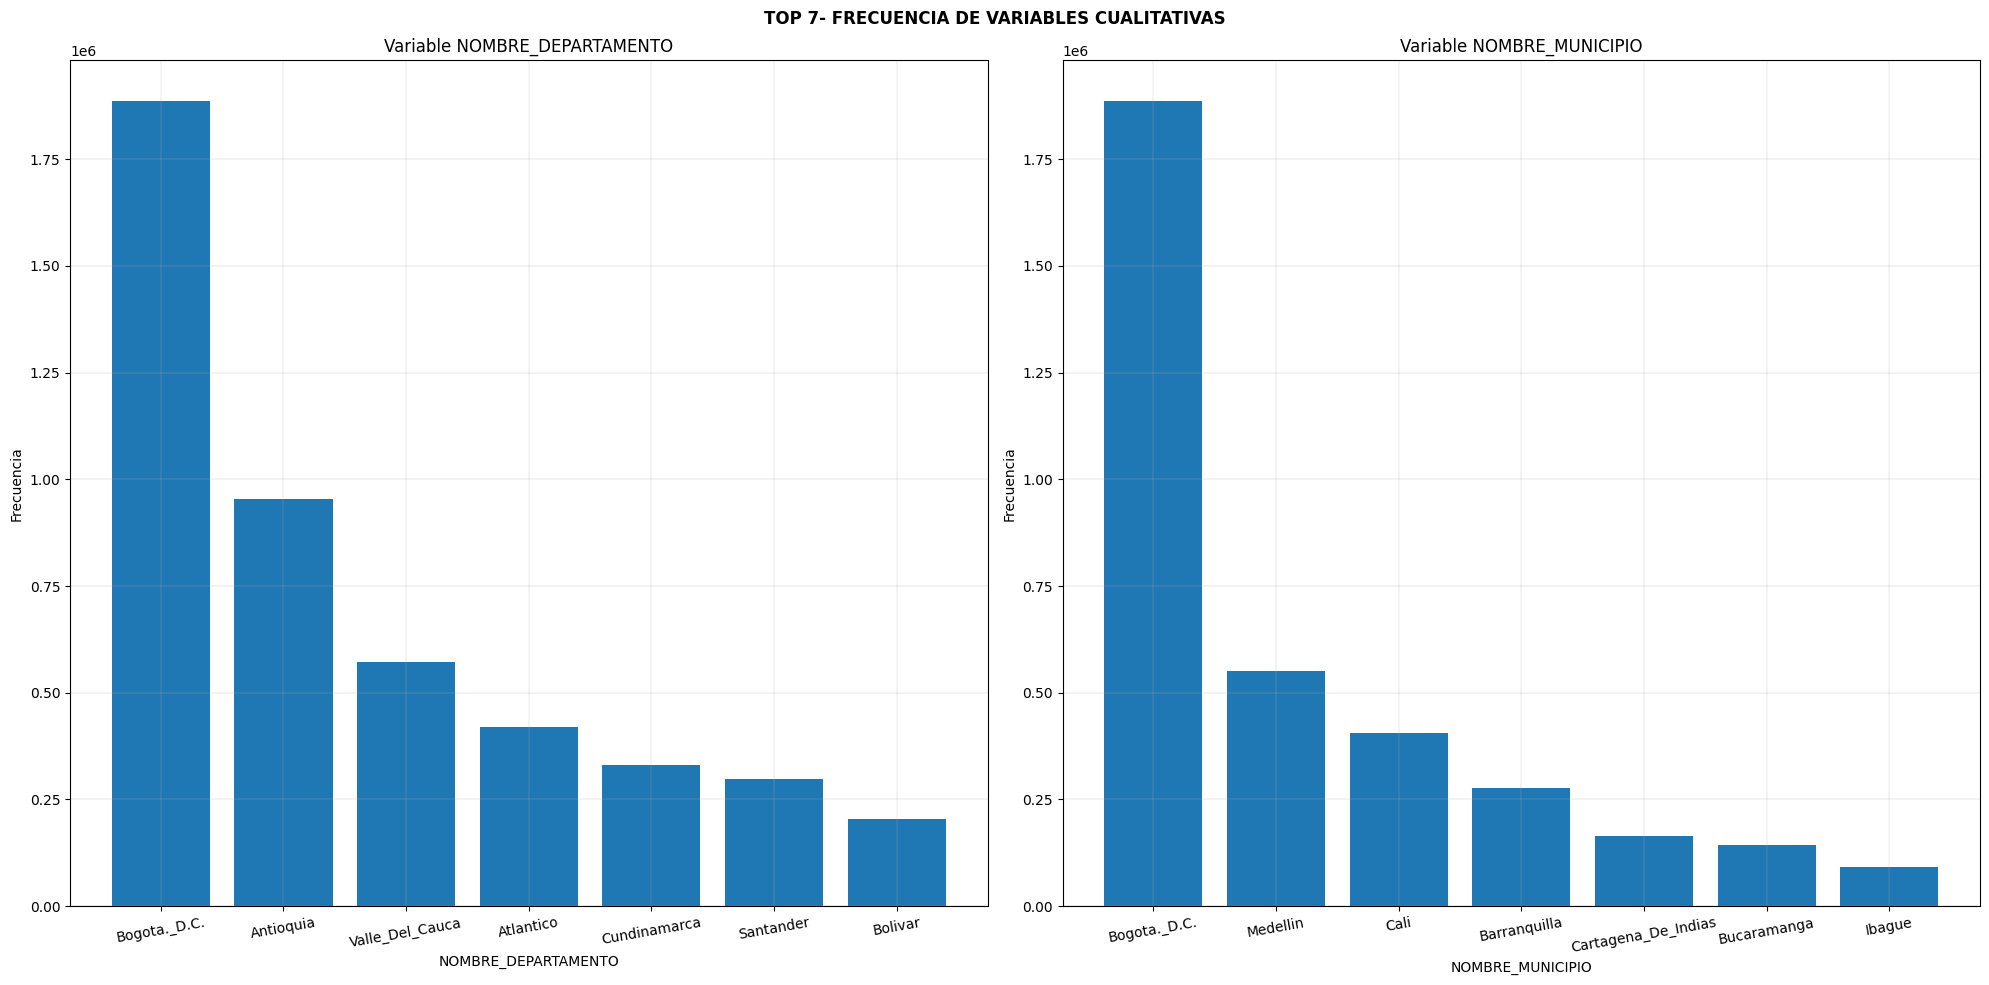

In [23]:
# Columnas con nombres de categorías largas - TOP 5
selected_columns = ['NOMBRE_DEPARTAMENTO', 'NOMBRE_MUNICIPIO']

# Filtrar el DataFrame para incluir solo las columnas especificadas
df_filtered = df_casos_covid_colombia[selected_columns]

# Crear una figura con una cuadrícula de 5x5
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Establecer el supertítulo
fig.suptitle('TOP 7- FRECUENCIA DE VARIABLES CUALITATIVAS', fontweight='extra bold')

# Iterar sobre las columnas y los ejes para crear los gráficos
for idx, col in enumerate(df_filtered.columns):
    # Calcular la fila y columna en la cuadrícula
    #row = idx // 1
    col_idx = idx % 2
    
    # Obtener el eje correspondiente en la cuadrícula
    ax = axes[col_idx]
    
    # Crear el gráfico de barras
    value_counts = df_filtered[col].value_counts().sort_values(ascending=False).iloc[0:7]
    # Convertir los índices a cadenas
    x_labels = [str(idx) for idx in value_counts.index]
    # Crear el gráfico de barras
    bars = ax.bar(x_labels, value_counts.values)

    
    # Establecer el título del gráfico
    ax.set_title(f'Variable {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frecuencia')
    ax.grid(linestyle='-', linewidth=0.2)
    ax.tick_params(axis='x', rotation=10)

# Ajustar el diseño y mostrar los gráficos
plt.tight_layout()
plt.show()

- Observamos que la frecuencia de casos en *Bogotá* es casi el doble que en *Antioquia*. Además, este top $7$ de departamentos con mayor frecuencia de casos coincide con los departamentos con mayor población del país.
- **Bogotá** presenta una frecuencia de casos más de *tres veces superior a la de Medellín*, que ocupa el segundo lugar. En cinco de los siete municipios del top 7, la capital del departamento coincide con la posición del departamento en su respectivo ranking. Esto indica que el comportamiento de estos municipios está bien reflejado por el comportamiento a nivel departamental. (tendremos esto encuenta para el BI)

La columna denominada `Nombre del país` contiene información sobre el país de posible contagio del virus para cada individuo. Esta variable para poder ser analizada primero será filtarada sin **Colombia**.

In [26]:
Paises = df_casos_covid_colombia[df_casos_covid_colombia['NOMBRE_PAIS'] != 'Colombia']
Paises

,FECHA_DE_NOTIFICACION,EDAD,UNIDAD_DE_MEDIDA_DE_EDAD,SEXO,TIPO_DE_CONTAGIO,UBICACION_DEL_CASO,ESTADO,RECUPERADO,FECHA_DE_INICIO_DE_SINTOMAS,FECHA_DE_MUERTE,FECHA_DE_DIAGNOSTICO,FECHA_DE_RECUPERACION,PERTENENCIA_ETNICA,NOMBRE_DEPARTAMENTO,NOMBRE_MUNICIPIO,NOMBRE_PAIS
1689,2020-11-23,30,Anios,F,Importado,Casa,Leve,Recuperado,2020-11-22,NaT,2020-11-24,2020-12-07,Otro,Antioquia,Medellin,Mexico
5295,2020-12-24,53,Anios,F,Importado,Casa,Leve,Recuperado,2020-12-24,NaT,2020-12-29,2021-01-07,Otro,Santander,Floridablanca,Mexico
12342,2020-11-25,22,Anios,M,Importado,Casa,Leve,Recuperado,2020-11-23,NaT,2020-11-25,2020-12-08,Otro,Antioquia,Envigado,Republica_Dominicana
14718,2020-05-19,32,Anios,M,Importado,Casa,Leve,Recuperado,2020-05-18,NaT,2020-05-25,2020-06-01,Otro,Bogota._D.C.,Bogota._D.C.,Alemania
14719,2020-05-19,23,Anios,M,Importado,Casa,Leve,Recuperado,2020-05-18,NaT,2020-05-25,2020-06-08,Otro,Bogota._D.C.,Bogota._D.C.,Francia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6382152,2021-12-27,46,Anios,F,Importado,Casa,Leve,Recuperado,2021-12-24,NaT,2022-01-01,2022-01-07,Otro,Valle_Del_Cauca,Cali,Estados_Unidos_De_America
6383593,2021-10-12,73,Anios,F,Importado,Fallecido,Fallecido,Fallecido,2021-10-08,2021-11-06,2021-10-23,NaT,Otro,Norte_De_Santander,Villa_Del_Rosario,Venezuela
6384909,2021-12-28,47,Anios,M,Importado,Casa,Leve,Recuperado,2021-12-24,NaT,2021-12-28,2022-01-07,Otro,Valle_Del_Cauca,Palmira,Estados_Unidos_De_America
6386995,2021-09-08,61,Anios,F,Importado,Casa,Leve,Recuperado,2021-09-01,NaT,2021-09-08,2021-09-15,Otro,Valle_Del_Cauca,Jamundi,Estados_Unidos_De_America


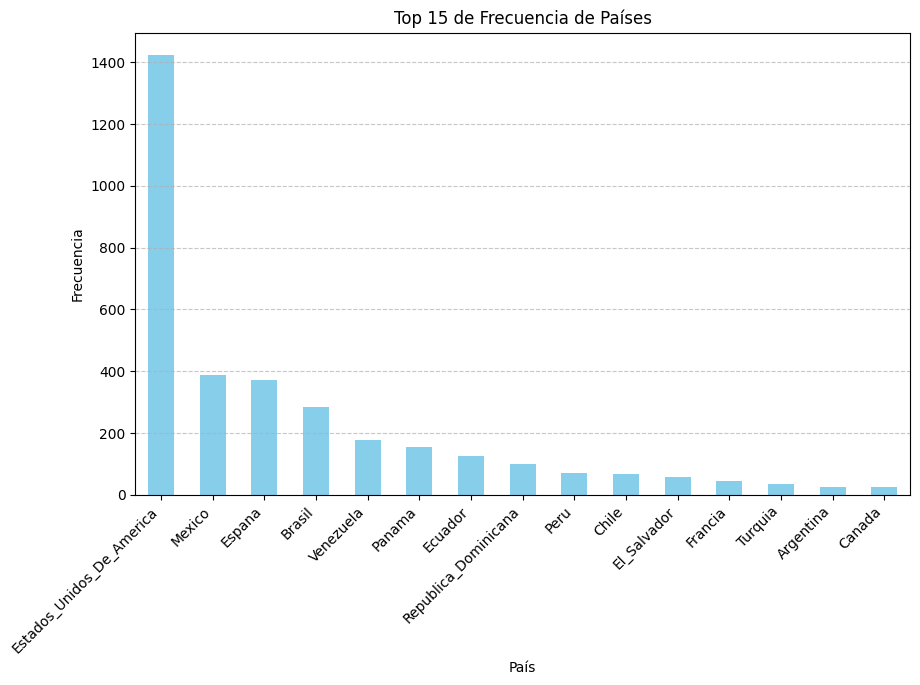

In [29]:
# Calcular la frecuencia de cada país
pais_frecuencia = Paises['NOMBRE_PAIS'].value_counts()

# Seleccionar los top 7 países con mayor frecuencia
top_paises = pais_frecuencia.head(15)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
top_paises.plot(kind='bar', color='skyblue')
plt.title('Top 15 de Frecuencia de Países')
plt.xlabel('País')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Queda claro que **Estados Unidos de América**, con un número de casos tres veces mayor que el de *México*, que ocupa el segundo lugar en el ranking, es el claro dominador. Además, en el top 15, nueve de los países son `hispanohablantes`. Cabe destacar que solo tres países de Europa completan el top 15, mientras que el resto pertenece al continente americano. Es importante mencionar que en este top 15 se concentra el $90.3\%$ aproximadamente de los casos registrados con procedencia diferente a `Colombia`.